#### IMPORT

In [1]:
import os, platform

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from matplotlib import pyplot


from keras.utils.np_utils import to_categorical 
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, \
    BatchNormalization, Flatten, LSTM
# from scikeras.wrappers import KerasClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc


from sklearn.metrics import roc_curve, auc

from itertools import cycle
from scipy import interp
from scipy.optimize import brentq
from scipy.interpolate import interp1d

#### PARAMETERS
- Set the condition
> * N_FEATURES: Number of Features
> * CHECK_BLANKS: Check for blank data. If any blank data is found, the whole row of data will be deleted.
> * CHECK_CLASS_IMBALANCE: Check for dataset class imbalance. The more balance the dataset, the less biases the model will be.

In [16]:
##############################
# # deep learning features # #
##############################
SEED = 1005 # random seed for reproducibility

# should make this dynamic
N_FEATURES = 578 #37 #98 #190 #61 #37 #46
# N_CLASSES= 9
TIMESTEPS = 1
EPOCH=200
BATCH_SIZE=100

###############
# # dataset # #
###############
DATASET_DIR_NAME = "dataset"
SAMPLE_DATASET_NAME = "m2m_train_nosum" + ".csv"
ACTUAL_DATASET_NAME = "m2m_test_flex_nosum" + ".csv"

# SAMPLE_DATASET_NAME = "train_m2m_tengraph" + ".csv"
# ACTUAL_DATASET_NAME = "test_m2m_tengraph" + ".csv"

# SAMPLE_DATASET_NAME = "andy" + ".csv"
# ACTUAL_DATASET_NAME = "andy" + ".csv"

MODEL_DIR_NAME = "model"
MODEL_NAME = "classifier" + ".h5"

DATASET_DIR_PATH = os.path.join(os.getcwd(), DATASET_DIR_NAME)
SAMPLE_DATASET_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME)
ACTUAL_DATASET_PATH = os.path.join(DATASET_DIR_PATH, ACTUAL_DATASET_NAME)

MODEL_DIR_PATH = os.path.join(os.getcwd(), MODEL_DIR_NAME)
MODEL_PATH = os.path.join(MODEL_DIR_PATH, MODEL_NAME)

CLASSES_COL_NAME = "Subject"
CLASSES_COL_NUM = 0
FEATURES_COL_NUM = 3 #6 #4
CLASS_LIST = ['adhy', 'alan', 'andy', 'bryce', 'chris', 'cy', 'gerald', 'jc', 'jonah', 'qk']
# CLASS_LIST = ['andy', 'azfar', 'gerald', 'jonah', 'ys']

#################
# # sns theme # #
#################
# sns.set_theme(style="darkgrid") # (dark background with white gridlines)
sns.set_theme(style="whitegrid") # (white background with grey gridlines)
# sns.set_theme(style="dark") # (dark background with no gridlines)
# sns.set_theme(style="white") # (white background with no gridlines)
# sns.set_theme(style="ticks") # (white background with axis ticks and no gridlines)

def df_drop(df):
    # df.drop(df[df['Subject']=='andy'].index, inplace=True)
    # df.drop(df[df['Subject']=='azfar'].index, inplace=True)
    df.drop(df[df['Subject']=='ch'].index, inplace=True)
    # df.drop(df[df['Subject']=='cy'].index, inplace=True)
    df.drop(df[df['Subject']=='gerald'].index, inplace=True)
    df.drop(df[df['Subject']=='jc'].index, inplace=True)
    df.drop(df[df['Subject']=='jonah'].index, inplace=True)
    df.drop(df[df['Subject']=='qikai'].index, inplace=True)
    df.drop(df[df['Subject']=='ys'].index, inplace=True)
    df.drop(df[df['Subject']=='zen'].index, inplace=True)
    
    return df

In [3]:
if os.path.isdir(DATASET_DIR_PATH) is True:
    print(f"Dataset directory exists at: {DATASET_DIR_PATH}")
    pass
else:
    try:
        os.mkdir(DATASET_DIR_PATH, 666)
        print(f"Dataset directory have been created at: {DATASET_DIR_PATH}")
    except:
        print("Error: Dataset Directory not created")
        
if os.path.isdir(MODEL_DIR_PATH) is True:
    print(f"Model directory exists at: {MODEL_DIR_PATH}")
    pass
else:
    try:
        os.mkdir(MODEL_DIR_PATH, 666)
        print(f"Model directory have been created at: {MODEL_DIR_PATH}")
    except:
        print("Error: Model Directory not created")

Dataset directory exists at: C:\Users\spencer\Documents\Github\deep-captcha\dataset
Model directory exists at: C:\Users\spencer\Documents\Github\deep-captcha\model


#### CREATE MODEL
- Create base model
- Wrap it with KerasClassifier

In [4]:
# create base model
def create_base_model():
    model = Sequential()
#     model.add(LSTM(units=128, return_sequences=True, 
#                  input_shape=(TIMESTEPS,N_FEATURES)))
#     model.add(Dropout(0.2))
#     model.add(BatchNormalization())
    model.add(LSTM(units=1024, return_sequences=True,
             input_shape=(TIMESTEPS,N_FEATURES)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=512, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=256, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=128, return_sequences=True))
    model.add(BatchNormalization())
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=32, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    # softmax for multi-class classification
    model.add(Flatten())
    print(n_classes)
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])
    return model

# wrap model in KerasClassifier
def create_model():
    model = KerasClassifier(build_fn=create_base_model, epochs=EPOCH, 
                            batch_size=BATCH_SIZE)
    return model



In [5]:
# divide data into features X and target (classes) Y
def prepare_dataset(df):
    X = df.values[:,FEATURES_COL_NUM:].astype(float)
    Y = df.values[:,CLASSES_COL_NUM].astype(str)

    # convert target Y to labelbinarizer Y for model
    # fit_transform is not used to reuse lb
    Y = Y.reshape(-1, 1)
    lb = LabelBinarizer().fit(Y)
    Y = lb.transform(Y)


    #################################
    # # get all the encoded class # #
    #################################
    print("LabelBinarizer is able to decipher: ")
    print(lb.classes_)
    print("\n")

    ###########################
    # # print X and Y shape # #
    ###########################
    print(f"X | Features | Dataset Shape: {X.shape}")
    print(f"Y | Classes  | Dataset Shape: {Y.shape}")

    return X, Y, lb

In [6]:
def split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED):

    ##############################################################
    # # split dataset into train and test set of 0.8/0.2 ratio # #
    ##############################################################
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=SPLIT_RATIO, random_state=SEED)

    ############################
    # # reshaping of dataset # #
    ############################

    # reshaping the dataset to include LSTM Timesteps
    print(X_train.dtype)
    X_train = np.asarray(X_train, dtype=np.float32)
    print(X_train.dtype)
    X_train = np.reshape(X_train, (X_train.shape[0], TIMESTEPS, X_train.shape[1]))
    print(X_test.dtype)
    X_test = np.asarray(X_test, dtype=np.float32)
    print(X_test.dtype)
    X_test = np.reshape(X_test, (X_test.shape[0], TIMESTEPS, X_test.shape[1]))

    # retrieve number of classes
    n_classes = y_train.shape[1]

    print(f"X train shape: {X_train.shape}")
    print(f"Y train shape: {y_train.shape}")
    print(f"X test shape: {X_test.shape}")
    print(f"Y test shape: {y_test.shape}")
    print(f"Number of Classes: {n_classes}")

    return X_train, X_test, y_train, y_test, n_classes

def reshape_dataset(X, TIMESTEPS):
    # reshaping the dataset to include LSTM Timesteps
    X = np.asarray(X, dtype=np.float32)
    X = np.reshape(X, (X.shape[0], TIMESTEPS, X.shape[1]))
    return X


#### CHECK DATASET

In [7]:
#     sns.catplot(x="Subject", y="D|0", data=df)

    
#     sns.catplot(x="Subject", y="D|1", hue="D|1", data=df, legend=False)
#     sns.catplot(x="Subject", y="D|3", hue="D|3", data=df, legend=False)
#     sns.catplot(x="Subject", y="D|4", hue="D|4", data=df, legend=False)
#     sns.catplot(x="Subject", y="D|5", hue="D|5", data=df, legend=False)
#     sns.catplot(x="Subject", y="D|6", hue="D|6", data=df, legend=False)
#     sns.catplot(x="Subject", y="D|7", hue="D|7", data=df, legend=False)
#     sns.catplot(x="Subject", y="D|8", hue="D|8", data=df, legend=False)

#     sns.catplot(x="Subject", y="D|1", hue="D|1", data=df, legend=False)
#     sns.catplot(x="Subject", y="I|1+2", hue="I|1+2", data=df, legend=False)
#     sns.catplot(x="Subject", y="PF|1+2", hue="PF|1+2", data=df, legend=False)
#     sns.catplot(x="Subject", y="RF|1+2", hue="RF|1+2", data=df, legend=False)
#     sns.catplot(x="Subject", y="DT|1+2", hue="DT|1+2", data=df, legend=False)
#     sns.catplot(x="Subject", y="D|9", hue="D|9", data=df, legend=False)


#     sns.catplot(x="Subject", y="TT|1+3", hue="TT|1+3", data=df, legend=False)
#     sns.catplot(x="Subject", y="QT|1+4", hue="QT|1+4", data=df, legend=False)

#### FIT AND SAVE MODEL
- Fitting of model
- Get Accuracy and Loss of Mdoel
- Saving Model

In [8]:
############################
# # reshaping of dataset # #
############################
# loading of dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)
df.head()

# df = df_drop(df)
dataset = df.values

# divide data into features X and target (classes) Y
# convert target Y to labelbinarizer Y for model
X, Y, lb = prepare_dataset(df)

# reshaping the dataset to include LSTM Timesteps
X = reshape_dataset(X, TIMESTEPS)
n_classes = Y.shape[1]

#####################
# # fit the model # #
#####################

model = create_model()
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                   verbose=0)
history = model.fit(X, Y, callbacks=es)

LabelBinarizer is able to decipher: 
['adhy' 'alan' 'andy' 'bryce' 'chris' 'cy' 'gerald' 'jc' 'jonah' 'qk']


X | Features | Dataset Shape: (63480, 578)
Y | Classes  | Dataset Shape: (63480, 10)
10
Epoch 1/200
635/635 [==============================] - 169s 139ms/step - loss: 1.2012 - accuracy: 0.5330
Epoch 2/200
635/635 [==============================] - 87s 136ms/step - loss: 0.9493 - accuracy: 0.6382
Epoch 3/200
635/635 [==============================] - 91s 144ms/step - loss: 0.8481 - accuracy: 0.6765
Epoch 4/200
635/635 [==============================] - 96s 151ms/step - loss: 0.7523 - accuracy: 0.7190
Epoch 5/200
635/635 [==============================] - 88s 139ms/step - loss: 0.6601 - accuracy: 0.7583
Epoch 6/200
635/635 [==============================] - 88s 138ms/step - loss: 0.5761 - accuracy: 0.7925
Epoch 7/200
635/635 [==============================] - 89s 140ms/step - loss: 0.5085 - accuracy: 0.8202
Epoch 8/200
635/635 [==============================] - 87s 137ms/step - l

635/635 [==============================] - 87s 138ms/step - loss: 0.0421 - accuracy: 0.9879
Epoch 78/200
635/635 [==============================] - 89s 140ms/step - loss: 0.0423 - accuracy: 0.9878
Epoch 79/200
635/635 [==============================] - 90s 141ms/step - loss: 0.0421 - accuracy: 0.9875
Epoch 80/200
635/635 [==============================] - 87s 137ms/step - loss: 0.0389 - accuracy: 0.9887
Epoch 81/200
635/635 [==============================] - 88s 138ms/step - loss: 0.0432 - accuracy: 0.9878
Epoch 82/200
635/635 [==============================] - 87s 136ms/step - loss: 0.0409 - accuracy: 0.9882
Epoch 83/200
635/635 [==============================] - 85s 134ms/step - loss: 0.0488 - accuracy: 0.9860
Epoch 84/200
635/635 [==============================] - 84s 132ms/step - loss: 0.0409 - accuracy: 0.9884
Epoch 85/200
635/635 [==============================] - 84s 132ms/step - loss: 0.0384 - accuracy: 0.9890
Epoch 86/200
635/635 [==============================] - 84s 133ms/st

635/635 [==============================] - 92s 144ms/step - loss: 0.0334 - accuracy: 0.9909
Epoch 155/200
635/635 [==============================] - 91s 144ms/step - loss: 0.0377 - accuracy: 0.9895
Epoch 156/200
635/635 [==============================] - 91s 143ms/step - loss: 0.0398 - accuracy: 0.9887
Epoch 157/200
635/635 [==============================] - 90s 142ms/step - loss: 0.0288 - accuracy: 0.9914
Epoch 158/200
635/635 [==============================] - 88s 138ms/step - loss: 0.0274 - accuracy: 0.9927
Epoch 159/200
635/635 [==============================] - 86s 135ms/step - loss: 0.0300 - accuracy: 0.9918
Epoch 160/200
635/635 [==============================] - 85s 135ms/step - loss: 0.0302 - accuracy: 0.9920
Epoch 161/200
635/635 [==============================] - 85s 134ms/step - loss: 0.0313 - accuracy: 0.9913
Epoch 162/200
635/635 [==============================] - 85s 134ms/step - loss: 0.0320 - accuracy: 0.9912
Epoch 163/200
635/635 [==============================] - 85s

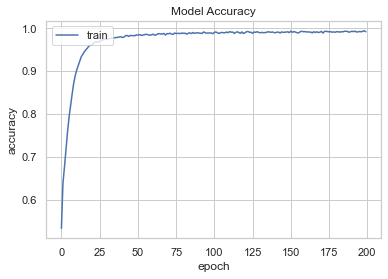

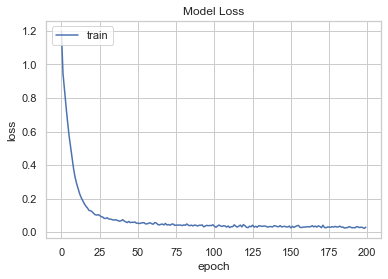

In [9]:
##########################
# # get model accuracy # #
##########################
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

######################
# # get model loss # #
######################
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#### SAVE MODEL

In [10]:
##################
# # save model # #
##################
model.model.save(MODEL_PATH)

# LIVE TESTING
> Live test with new dataset to check if model function as it should

#### LOAD MODEL

In [11]:
##################
# # load model # #
##################

# model = create_model()
model = load_model(MODEL_PATH)

#### LOAD DATA
- Import new dataset to verify the model is able to predict accurately

In [17]:
# import unseen data
pred_df = pd.read_csv(ACTUAL_DATASET_PATH)
pred_df.head()
# pred_df = df_drop(pred_df)

,Subject,Seq_No,Sequence,D|0,I|0+1,PF|0+1,RF|0+1,DT|0+1,D|1,I|1+2,PF|1+2,RF|1+2,DT|1+2,D|2,I|2+3,PF|2+3,RF|2+3,DT|2+3,D|3,I|3+4,PF|3+4,RF|3+4,DT|3+4,D|4,I|4+5,PF|4+5,RF|4+5,DT|4+5,D|5,I|5+6,PF|5+6,RF|5+6,DT|5+6,D|6,I|6+7,PF|6+7,RF|6+7,DT|6+7,D|7,I|7+8,PF|7+8,RF|7+8,DT|7+8,D|8,I|8+9,PF|8+9,RF|8+9,DT|8+9,D|9,T2-D-M,T2-I-M,T2-PF-M,T2-RF-M,T2-DT-M,T2-D-VAR,T2-I-VAR,T2-PF-VAR,T2-RF-VAR,T2-DT-VAR,T2-D-SD,T2-I-SD,T2-PF-SD,T2-RF-SD,T2-DT-SD,T3_I|0+2,T3_PF|0+2,T3_RF|0+2,T3_G|0+2,T3_I|1+3,T3_PF|1+3,T3_RF|1+3,T3_G|1+3,T3_I|2+4,T3_PF|2+4,T3_RF|2+4,T3_G|2+4,T3_I|3+5,T3_PF|3+5,T3_RF|3+5,T3_G|3+5,T3_I|4+6,T3_PF|4+6,T3_RF|4+6,T3_G|4+6,T3_I|5+7,T3_PF|5+7,T3_RF|5+7,T3_G|5+7,T3_I|6+8,T3_PF|6+8,T3_RF|6+8,T3_G|6+8,T3_I|7+9,T3_PF|7+9,T3_RF|7+9,T3_G|7+9,T3-I-M,T3-PF-M,T3-RF-M,T3-G-M,T3-I-VAR,T3-PF-VAR,T3-RF-VAR,T3-G-VAR,T3-I-SD,T3-PF-SD,T3-RF-SD,T3-G-SD,T4_I|0+3,T4_PF|0+3,T4_RF|0+3,T4_G|0+3,T4_I|1+4,T4_PF|1+4,T4_RF|1+4,T4_G|1+4,T4_I|2+5,T4_PF|2+5,T4_RF|2+5,T4_G|2+5,T4_I|3+6,T4_PF|3+6,T4_RF|3+6,T4_G|3+6,T4_I|4+7,T4_PF|4+7,T4_RF|4+7,T4_G|4+7,T4_I|5+8,T4_PF|5+8,T4_RF|5+8,T4_G|5+8,T4_I|6+9,T4_PF|6+9,T4_RF|6+9,T4_G|6+9,T4-I-M,T4-PF-M,T4-RF-M,T4-G-M,T4-I-VAR,T4-PF-VAR,T4-RF-VAR,T4-G-VAR,T4-I-SD,T4-PF-SD,T4-RF-SD,T4-G-SD,T5_I|0+4,T5_PF|0+4,T5_RF|0+4,T5_G|0+4,T5_I|1+5,T5_PF|1+5,T5_RF|1+5,T5_G|1+5,T5_I|2+6,T5_PF|2+6,T5_RF|2+6,T5_G|2+6,T5_I|3+7,T5_PF|3+7,T5_RF|3+7,T5_G|3+7,T5_I|4+8,T5_PF|4+8,T5_RF|4+8,T5_G|4+8,T5_I|5+9,T5_PF|5+9,T5_RF|5+9,T5_G|5+9,T5-I-M,T5-PF-M,T5-RF-M,T5-G-M,T5-I-VAR,T5-PF-VAR,T5-RF-VAR,T5-G-VAR,T5-I-SD,T5-PF-SD,T5-RF-SD,T5-G-SD,T6_I|0+5,T6_PF|0+5,T6_RF|0+5,T6_G|0+5,T6_I|1+6,T6_PF|1+6,T6_RF|1+6,T6_G|1+6,T6_I|2+7,T6_PF|2+7,T6_RF|2+7,T6_G|2+7,T6_I|3+8,T6_PF|3+8,T6_RF|3+8,T6_G|3+8,T6_I|4+9,T6_PF|4+9,T6_RF|4+9,T6_G|4+9,T6-I-M,T6-PF-M,T6-RF-M,T6-G-M,T6-I-VAR,T6-PF-VAR,T6-RF-VAR,T6-G-VAR,T6-I-SD,T6-PF-SD,T6-RF-SD,T6-G-SD,T7_I|0+6,T7_PF|0+6,T7_RF|0+6,T7_G|0+6,T7_I|1+7,T7_PF|1+7,T7_RF|1+7,T7_G|1+7,T7_I|2+8,T7_PF|2+8,T7_RF|2+8,T7_G|2+8,T7_I|3+9,T7_PF|3+9,T7_RF|3+9,T7_G|3+9,T7-I-M,T7-PF-M,T7-RF-M,T7-G-M,T7-I-VAR,T7-PF-VAR,T7-RF-VAR,T7-G-VAR,T7-I-SD,T7-PF-SD,T7-RF-SD,T7-G-SD,T8_I|0+7,T8_PF|0+7,T8_RF|0+7,T8_G|0+7,T8_I|1+8,T8_PF|1+8,T8_RF|1+8,T8_G|1+8,T8_I|2+9,T8_PF|2+9,T8_RF|2+9,T8_G|2+9,T8-I-M,T8-PF-M,T8-RF-M,T8-G-M,T8-I-VAR,T8-PF-VAR,T8-RF-VAR,T8-G-VAR,T8-I-SD,T8-PF-SD,T8-RF-SD,T8-G-SD,T9_I|0+8,T9_PF|0+8,T9_RF|0+8,T9_G|0+8,T9_I|1+9,T9_PF|1+9,T9_RF|1+9,T9_G|1+9,T9-I-M,T9-PF-M,T9-RF-M,T9-G-M,T9-I-VAR,T9-PF-VAR,T9-RF-VAR,T9-G-VAR,T9-I-SD,T9-PF-SD,T9-RF-SD,T9-G-SD,T10_I|0+9,T10_PF|0+9,T10_RF|0+9,T10_G|0+9,D|0.1,I|0+1.1,PF|0+1.1,RF|0+1.1,DT|0+1.1,D|1.1,I|1+2.1,PF|1+2.1,RF|1+2.1,DT|1+2.1,D|2.1,I|2+3.1,PF|2+3.1,RF|2+3.1,DT|2+3.1,D|3.1,I|3+4.1,PF|3+4.1,RF|3+4.1,DT|3+4.1,D|4.1,I|4+5.1,PF|4+5.1,RF|4+5.1,DT|4+5.1,D|5.1,I|5+6.1,PF|5+6.1,RF|5+6.1,DT|5+6.1,D|6.1,I|6+7.1,PF|6+7.1,RF|6+7.1,DT|6+7.1,D|7.1,I|7+8.1,PF|7+8.1,RF|7+8.1,DT|7+8.1,D|8.1,I|8+9.1,PF|8+9.1,RF|8+9.1,DT|8+9.1,D|9.1,T2-D-M.1,T2-I-M.1,T2-PF-M.1,T2-RF-M.1,T2-DT-M.1,T2-D-VAR.1,T2-I-VAR.1,T2-PF-VAR.1,T2-RF-VAR.1,T2-DT-VAR.1,T2-D-SD.1,T2-I-SD.1,T2-PF-SD.1,T2-RF-SD.1,T2-DT-SD.1,T3_I|0+2.1,T3_PF|0+2.1,T3_RF|0+2.1,T3_G|0+2.1,T3_I|1+3.1,T3_PF|1+3.1,T3_RF|1+3.1,T3_G|1+3.1,T3_I|2+4.1,T3_PF|2+4.1,T3_RF|2+4.1,T3_G|2+4.1,T3_I|3+5.1,T3_PF|3+5.1,T3_RF|3+5.1,T3_G|3+5.1,T3_I|4+6.1,T3_PF|4+6.1,T3_RF|4+6.1,T3_G|4+6.1,T3_I|5+7.1,T3_PF|5+7.1,T3_RF|5+7.1,T3_G|5+7.1,T3_I|6+8.1,T3_PF|6+8.1,T3_RF|6+8.1,T3_G|6+8.1,T3_I|7+9.1,T3_PF|7+9.1,T3_RF|7+9.1,T3_G|7+9.1,T3-I-M.1,T3-PF-M.1,T3-RF-M.1,T3-G-M.1,T3-I-VAR.1,T3-PF-VAR.1,T3-RF-VAR.1,T3-G-VAR.1,T3-I-SD.1,T3-PF-SD.1,T3-RF-SD.1,T3-G-SD.1,T4_I|0+3.1,T4_PF|0+3.1,T4_RF|0+3.1,T4_G|0+3.1,T4_I|1+4.1,T4_PF|1+4.1,T4_RF|1+4.1,T4_G|1+4.1,T4_I|2+5.1,T4_PF|2+5.1,T4_RF|2+5.1,T4_G|2+5.1,T4_I|3+6.1,T4_PF|3+6.1,T4_RF|3+6.1,T4_G|3+6.1,T4_I|4+7.1,T4_PF|4+7.1,T4_RF|4+7.1,T4_G|4+7.1,T4_I|5+8.1,T4_PF|5+8.1,T4_RF|5+8.1,T4_G|5+8.1,T4_I|6+9.1,T4_PF|6+9.1,T4_RF|6+9.1,T4_G|6+9.1,T4-I-M.1,T4-PF-M.1,T4-RF-M.1,T4-G-M.1,T4-I-VAR.1,T4-PF-VAR.1,T4-RF-VAR.1,T4-G-VAR.1,T4-I-SD.1,T4-PF-SD.1,T4-RF-SD.1,T4-G-SD.1,T

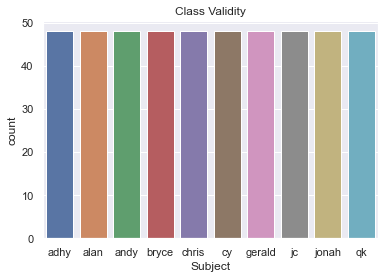

In [18]:
################################
# # check for class validity # #
################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Subject", data=pred_df).set_title("Class Validity")

# remove missing values if available
pred_df = pred_df.dropna()

In [19]:
pred_dataset = pred_df.values
results = pred_dataset[:,CLASSES_COL_NUM]

# # divide data into features X
# pred_row = pred_dataset[:,3:].astype(float)

########################
# # predict all rows # #
########################
pred_row=pred_df.iloc[:,FEATURES_COL_NUM:]

#################################
# # predict more than one row # #
#################################

# pred_row=pred_df.iloc[46:54,FEATURES_COL_NUM:]
# print(pred_row)

############################
# # predict a single row # #
############################

# pred_row=pred_df.iloc[11:12,FEATURES_COL_NUM:]

##################
# # shape data # #
##################
pred_row = pred_row.values.tolist()
pred_arr = np.asarray(pred_row, dtype=np.float32)
pred_arr = np.reshape(pred_arr, (pred_arr.shape[0], TIMESTEPS, pred_arr.shape[1]))

Y = CLASS_LIST
print(Y)
Y = np.asarray(Y)
Y = Y.reshape(-1, 1)
lb = LabelBinarizer().fit(Y)
Y = lb.transform(Y)

['adhy', 'alan', 'andy', 'bryce', 'chris', 'cy', 'gerald', 'jc', 'jonah', 'qk']


In [20]:
####################################
# # get prediction and its label # #
####################################

pred_proba = model.predict(pred_arr)

# pred_proba = np.sum(pred_proba, axis=0)
# pred_proba = np.reshape(pred_proba, (1, 9))

pred = lb.inverse_transform(pred_proba)
acc = np.max(pred_proba, axis=1)

pred_results = np.column_stack((pred, acc))
pred_results = np.column_stack((results, pred_results))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.DataFrame(data=pred_results, index=None, columns=['Results', 'Prediction', 'Accuracy'])
# df = pd.DataFrame(data=pred_results, index=None, columns=['Prediction', 'Accuracy'])
print(df)

df.to_csv("results_flex_nosum.csv")

# =IF(EXACT(B2, C2), "Match", "Nope")

    Results Prediction    Accuracy
0      adhy       adhy   0.9999827
1      adhy      jonah   0.7502297
2      adhy      bryce   0.9994423
3      adhy      jonah  0.99958926
4      adhy         qk   0.9745769
5      adhy       adhy   0.9999759
6      adhy       adhy  0.99989617
7      adhy      jonah   0.7910135
8      adhy      bryce  0.99909925
9      adhy      jonah   0.9980627
10     adhy         qk   0.7743923
11     adhy       adhy  0.99997413
12     adhy      bryce   0.8041713
13     adhy      bryce   0.4855283
14     adhy      bryce  0.99986434
15     adhy      jonah  0.99943405
16     adhy         cy   0.4979516
17     adhy       adhy   0.9999764
18     adhy      bryce   0.3360576
19     adhy      bryce  0.46914336
20     adhy      bryce   0.9813514
21     adhy      jonah   0.9996779
22     adhy         cy  0.99148655
23     adhy       adhy  0.99998176
24     adhy      chris   0.8708846
25     adhy      bryce  0.62027556
26     adhy       adhy  0.99998534
27     adhy      jon